In [1]:
import igraph as ig
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_mutual_info_score as AMI
import partition_igraph
from matplotlib import pyplot as plt
from collections import Counter
import random
import pickle
import os
import seaborn as sns
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import roc_curve
from scipy.sparse import csr_matrix
import scipy.sparse as sparse 
import time
from statistics import mode
from abcd_graph import ABCDGraph, ABCDParams
import csv
import subprocess
import sys
sys.path.append('../../')
from CAS import *


## ABCD-oo graphs

Main 2 files:

```
networkfile<xi>_<eta>_<rep>.txt : the edges, 1-based node ids, tab separated
communityfile<xi>_<eta>_<rep>.txt : node <tab> list of communities in [], for example:
1       [24]
2       [3, 28]
3       [10]
```


In [2]:
path = './abcdoo_yt_'
def readGraph(xi=0.1, eta=1.25, n=1000):
    ## read edges, build graph
    fn = path+str(xi)+'_'+str(eta)+'_'+str(n)+'_edge.dat'
    Edges = pd.read_csv(fn, sep='\t', header=None)-1 ## map to 0-based
    G = ig.Graph.DataFrame(Edges, directed=False)
    ## read communities
    fn = path+str(xi)+'_'+str(eta)+'_'+str(n)+'_com.dat'
    L = []
    with open(fn, "r") as infile:
        for line in infile:
            x = line.split('\t')
            L.append([int(y)-1 for y in x[1].rstrip()[1:-1].split(',')]) ## map to 0-based
    G.vs['comms'] = L
    G.vs['n_comms'] = [len(x) for x in G.vs['comms']]
    return G
   

In [3]:
oNMI = '/Users/francois/Book/GraphMiningNotebooks/oNMI/onmi'          ## overlapping NMI executable
#oNMI = '/work/home/fcthebe/Tools/oNMI/onmi'          ## overlapping NMI executable

## input format: 
def compute_oNMI(First, Second):
    fn1 = '__'+str(random.random())[2:]
    with open(fn1,"w") as f:
        wr = csv.writer(f, delimiter=" ")
        wr.writerows(First)
    f.close()   

    fn2 = '__'+str(random.random())[2:]
    with open(fn2,"w") as f:
        wr = csv.writer(f, delimiter=" ")
        wr.writerows(Second)
    f.close()   
    x = float(subprocess.check_output([oNMI,fn1,fn2]).decode("utf-8").split()[1])
    _ = os.system('rm '+fn1)
    _ = os.system('rm '+fn2)
    return x


In [4]:
def memberships2list(S):
    L = []
    for i in range(len(S.indptr)-1):
        if S.indptr[i] == S.indptr[i+1]:
            L.append([0]) ## no membership == outlier (community 0)
        else:
            L.append(list(S.indices[S.indptr[i]:S.indptr[i+1]]+1)) ## 1-based
    return L

## given list of node memberships, return list of communities
def mems2comms(X):
    nc = max(set([i for j in X for i in j]))+1  
    n = len(X)
    L = [[] for _ in range(nc)]
    for i in range(n):
        for j in X[i]:
            L[j].append(i)
    return L

In [5]:
from itertools import combinations
def CPM(g, k=3):
    cls = list(map(set, g.cliques(min=k,max=k)))
    edgelist = []
    for i in range(len(cls)):
        edgelist.append((i,i))
    for i,j in combinations(range(len(cls)),2):
        if len(cls[i].intersection(cls[j])) >= (k-1):
            edgelist.append((i,j))
    cg = ig.Graph(edgelist, directed=False)
    clusters = cg.connected_components()
    L = []
    for cluster in clusters:
        members = set()
        for i in cluster:
            members.update(cls[i])
        L.append(set(g.vs[members]["name"]))
    return L


In [6]:
def EgoSplit(G, split='CC', algo='LP'):
    g = G.copy()
    ## implement ego-split approach with LP or ECG
    g.vs['original'] = g.vs['name']
    ## use the vertex names to avoid issues when vertices are re-mapped ...
    names = g.vs['name']
    ## step 1 - ego-net splits
    #ctr = 1
    for nm in names:
#         if ctr%1000==0:
#             print(ctr)
#         ctr+=1
        v = g.vs.find(nm).index
        n = g.neighbors(v)
        sg = g.subgraph(n)
        if split == 'LP':
            x = sg.community_label_propagation().membership
        else:
            x = sg.connected_components().membership
        if np.min(x)==-1:
            x = [i+1 for i in x]
        for j in set(x):
            g.add_vertex(name=nm+'.'+str(j),original=nm)

        l = sg.vs['name']
        for j in range(len(x)):
            g.add_edge(nm+'.'+str(x[j]) , l[j])
        g.delete_vertices(v)
    ## step 2 -- cluster w.r.t. multiple personae
    if algo=='LP':
        cl = g.community_label_propagation()
    else:
        cl = g.community_ecg(ens_size=32)
    C = [set(sg.vs['original']) for sg in cl.subgraphs()]
    return C


In [7]:
def Jaccard(a,b):
    x = len(set(a).intersection(set(b)))/len(set(a).union(set(b)))
    return x

def weightedLinegraph(g):
    lg = g.linegraph()
    w=[]
    for e in lg.es:
        A = set(g.es[e.tuple[0]].tuple)
        B = set(g.es[e.tuple[1]].tuple)
        x = list((A-B).union(B-A))
        w.append(Jaccard(g.neighbors(x[0]),g.neighbors(x[1])))
    lg.es['weight'] = w
    return lg

def edgeCluster(g, color=False):
    q = -999
    D = weightedLinegraph(g)
    for th in sorted(set(D.es['weight'])):
        ## filter edges w.r.t. similarity and find CC
        dg = D.copy()
        dg.delete_edges([e for e in dg.es if e['weight']<=th])
        cc = dg.connected_components().membership
        mod = D.modularity(cc)
        if mod>q:
            q = mod
            g.es['lc'] = cc
            if color:
                pal = ig.ClusterColoringPalette(n=max(cc)+1)
                for e in g.es:
                    e['color'] = pal[e['lc']]
    ## Now gather the nodes for each edge cluster
    L = []
    for i in range(max(g.es['lc'])+1):
        sg = g.subgraph_edges([e for e in g.es if e['lc']==i])
        L.append(sg.vs['name'])
    return L

## Quick test

In [8]:
xi = 0.1
eta = 1.25
n=1000

G = readGraph(xi=xi,eta=eta)
G.vs['name'] = [str(i) for i in np.arange(G.vcount())]
GT = mems2comms(G.vs['comms'])[1:]  ## no "outlier community"
GT = [[str(i) for i in x] for x in GT]

In [9]:
%%time
CP = CPM(G)


CPU times: user 2.21 s, sys: 21 ms, total: 2.23 s
Wall time: 2.26 s


In [10]:
%%time
G.vs['leiden'] = G.community_leiden(objective_function='modularity').membership
LD = mems2comms([[x] for x in G.vs['leiden']])
LD = [[str(i) for i in j] for j in LD]


CPU times: user 2.48 ms, sys: 204 μs, total: 2.68 ms
Wall time: 2.69 ms


In [11]:
%%time
comms_es = EgoSplit(G, split='CC', algo='ECG')
ES = [list(x) for x in comms_es if len(x)>=10]


CPU times: user 2.14 s, sys: 48.9 ms, total: 2.19 s
Wall time: 2.23 s


In [12]:
%%time
C = sparse.csc_matrix((G.vcount(),len(ES)))
C.indices = np.array([int(i) for j in ES for i in j])
C.data = np.repeat(1,len(C.indices))
ptr = [0]
ctr = 0
for x in ES:
    ctr += len(x)
    ptr.append(ctr)
C.indptr = np.array(ptr)
M = C.tocsr()
## Beta
IEF, Beta, C, Pv, DegPart = CAS(G.get_adjacency_sparse(), M)
L = []
th = 0.25
for i in range(IEF.shape[1]):
    x = np.where( (np.array(IEF[:,i].todense()).flatten() >= th))[0]
    if len(x)>0:
        L.append(list(x))        

CPU times: user 119 ms, sys: 3.31 ms, total: 123 ms
Wall time: 123 ms


In [13]:
compute_oNMI(L,ES)

0.672744

In [14]:
X = [eta, compute_oNMI( CP, GT ), compute_oNMI( LD, GT ), compute_oNMI( ES, GT ), compute_oNMI(GT, L), xi]
print(X)


[1.25, 0.00421149, 0.449301, 0.476964, 0.608151, 0.1]


In [15]:
%%time
EC = edgeCluster(G)
_EC = [x for x in EC if len(x) >= 10]
compute_oNMI(_EC,GT)


CPU times: user 30.7 s, sys: 750 ms, total: 31.5 s
Wall time: 31.7 s


0.224832

## Compare algorithms: CPM, Leiden, Ego-Split, ES+Beta, Edge clustering


In [16]:
Results = []
for n in [1000,1500,2000,2500,3000,3500,4000,4500,5000,6000,7000,8000,9000,10000]:
    X = [n]
    
    G = readGraph(n=n)
    G.vs['name'] = [str(i) for i in np.arange(G.vcount())]
    GT = mems2comms(G.vs['comms'])[1:]  ## ignore "outlier community"
    GT = [[str(i) for i in x] for x in GT]
    
    ## CPM
    a = time.time()
    CP = CPM(G)
    X.append(time.time()-a)
    
    ## Leiden
    a = time.time()
    G.vs['leiden'] = G.community_leiden(objective_function='modularity').membership
    X.append(time.time()-a)

    ## Ego
    a = time.time()
    comms_es = EgoSplit(G, split='CC', algo='ECG')
    X.append(time.time()-a)

    ES = [list(x) for x in comms_es if len(x)>=10]

    C = sparse.csc_matrix((G.vcount(),len(ES)))
    C.indices = np.array([int(i) for j in ES for i in j])
    C.data = np.repeat(1,len(C.indices))
    ptr = [0]
    ctr = 0
    for x in ES:
        ctr += len(x)
        ptr.append(ctr)
    C.indptr = np.array(ptr)
    M = C.tocsr()

    ## Beta
    a = time.time()
    IEF, Beta, C, Pv, DegPart = CAS(G.get_adjacency_sparse(), M)
    X.append(time.time()-a)

    ## Edge clustering
    a = time.time()
    _EC = edgeCluster(G)
    X.append(time.time()-a)
 
    print(X)
    Results.append(X)
        
df = pd.DataFrame(Results, columns=['n','cpm','leiden','ego','beta','edge'])
with open('algo_compare_time.pkl','wb') as fp:
    pickle.dump(df,fp)    

[1000, 2.2221100330352783, 0.002349853515625, 2.2185280323028564, 0.1384410858154297, 31.37585711479187]
[1500, 3.7291107177734375, 0.003659963607788086, 5.5174400806427, 0.16595101356506348, 57.56233596801758]
[2000, 5.8887810707092285, 0.004639863967895508, 10.213411092758179, 0.25574612617492676, 73.21046566963196]
[2500, 12.378602981567383, 0.005759000778198242, 16.3884699344635, 0.29105615615844727, 119.45386910438538]
[3000, 16.83968496322632, 0.006811857223510742, 23.309485912322998, 0.3495790958404541, 146.00099110603333]
[3500, 23.063987970352173, 0.008348941802978516, 32.91121196746826, 0.429826021194458, 182.75384879112244]
[4000, 23.624012231826782, 0.009184837341308594, 43.82585310935974, 0.5026419162750244, 185.98212313652039]
[4500, 29.95846676826477, 0.010456085205078125, 52.28928089141846, 0.5160279273986816, 226.11249613761902]
[5000, 34.620689868927, 0.01270604133605957, 68.12565898895264, 0.535297155380249, 274.9127380847931]
[6000, 53.536718130111694, 0.01737713813

In [17]:
with open('./algo_compare_time.pkl','rb') as fp:
    df = pickle.load(fp)
df.columns = ['n', 'CPM', 'Leiden', 'EgoSplit', 'IEF', 'Edge']

In [18]:
df['IEF'] = df['EgoSplit']+df['IEF']

## Plots for WAW ABCD-oo paper

In [19]:
from matplotlib import colormaps
import matplotlib.colors as colors
cmap = colormaps.get_cmap('mako')
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = truncate_colormap(cmap,0,.85)


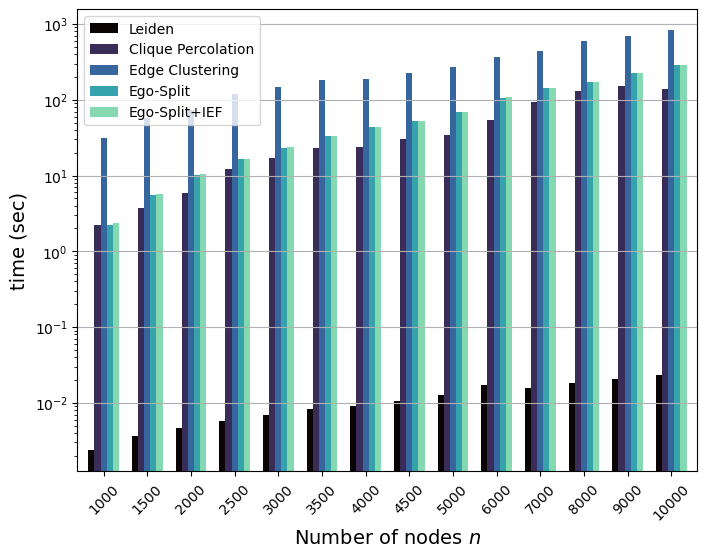

In [27]:
df.plot(x='n',y=['Leiden', 'CPM', 'Edge', 'EgoSplit', 'IEF'], 
                    kind='bar', figsize=(8,6), colormap=cmap, logy=True, width=.7)
plt.grid(axis='y')
plt.legend(['Leiden','Clique Percolation','Edge Clustering','Ego-Split','Ego-Split+IEF'])
plt.xlabel(r'Number of nodes $n$', fontsize=14)
plt.ylabel('time (sec)', fontsize=14)
plt.xticks(rotation=45)
plt.savefig('compare_algos_eta.png');
